<a href="https://colab.research.google.com/github/gaurav4288/Machine_learning/blob/main/33_PCA_Sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240731%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240731T104041Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1219d06157e0f570d41e83b10ec39607dc638c8efa991ff41371da64541b187c038a575905442d9aac436baeb027251729ca7e82c0a3717a816fd8d72825a7307b29b4cc3cb7e1adcb2ad729a065350349a95a4fe61bab70d1e8d49a945bc2cf4157479479fe51ac81da772332ef404ade5b75f59aa0d0d7f6db4df743468e68fb2cb409a21917d5a97d2820d0540cfc593051487810c0a41f1e3cf75f89228e6fcafd35a110dc3103c9f091939a4c9250bfd0a08afa8bc155995d0ab3614888ebe0c54b4076e892c1dd3b08f99068a33508ccf545e7ec77e3fd27114588613c76cb833f067c792c0a63164452b21180ad3485372f75d8ecd747452dab2601ad'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [4]:
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [5]:
df.shape

(42000, 785)

In [6]:
df.sample(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
7742,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30476,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34863,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29951,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18586,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
import matplotlib.pyplot as plt

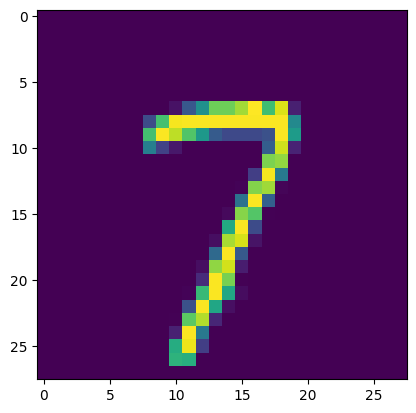

In [8]:
plt.imshow(df.iloc[18,1:].values.reshape(28,28))

In [9]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [11]:
X_train.shape

(33600, 784)

In [12]:
from sklearn.neighbors import KNeighborsClassifier

In [13]:
knn = KNeighborsClassifier()

In [14]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [15]:
import time
start = time.time()
y_pred = knn.predict(X_test)
print(time.time() - start)

23.383395671844482


In [16]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9648809523809524

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [18]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=200)

In [20]:
X_train_trf = pca.fit_transform(X_train)
X_test_trf = pca.transform(X_test)

In [21]:
X_train_trf.shape

(33600, 200)

In [22]:
knn = KNeighborsClassifier()

In [23]:
knn.fit(X_train_trf,y_train)

KNeighborsClassifier()

In [24]:
y_pred = knn.predict(X_test_trf)

In [25]:
accuracy_score(y_test,y_pred)

0.9504761904761905

In [27]:
# for i in range(1,784):
#     pca = PCA(n_components=i)
#     X_train_trf = pca.fit_transform(X_train)
#     X_test_trf = pca.transform(X_test)

#     knn = KNeighborsClassifier()

#     knn.fit(X_train_trf,y_train)

#     y_pred = knn.predict(X_test_trf)

#     print(accuracy_score(y_test,y_pred))


In [ ]:
# transforming to a 2D coordinate system
pca = PCA(n_components=2)
X_train_trf = pca.fit_transform(X_train)
X_test_trf = pca.transform(X_test)

In [28]:
X_train_trf

array([[-2.71863253, -0.4898241 ,  1.1354966 , ...,  0.81145162,
         0.1919221 , -0.61084264],
       [-0.67698015, -6.75362492, -2.3359014 , ..., -0.88025516,
        -0.27858188, -2.54515391],
       [-3.03323281,  6.50981624,  7.49182983, ...,  0.96413291,
        -2.41402098,  0.60319836],
       ...,
       [ 2.14883643,  0.78079444, -0.74738774, ...,  0.82982354,
         0.61109514,  1.30332798],
       [ 1.05957006,  0.94767312,  3.94973115, ..., -0.13241986,
         0.43130351,  0.22608058],
       [17.70258446,  1.96188184, -4.94352838, ...,  0.54951466,
        -0.60792927,  0.0500638 ]])

In [29]:
import plotly.express as px
y_train_trf = y_train.astype(str)
fig = px.scatter(x=X_train_trf[:,0],
                 y=X_train_trf[:,1],
                 color=y_train_trf,
                 color_discrete_sequence=px.colors.qualitative.G10
                )
fig.show()

In [30]:
# transforming in 3D
pca = PCA(n_components=3)
X_train_trf = pca.fit_transform(X_train)
X_test_trf = pca.transform(X_test)

In [31]:
X_train_trf

array([[-2.71864151, -0.4890464 ,  1.13547763],
       [-0.67700107, -6.75495437, -2.33695541],
       [-3.03320868,  6.50918279,  7.49196896],
       ...,
       [ 2.14884031,  0.78035921, -0.74743155],
       [ 1.05956812,  0.94880388,  3.949797  ],
       [17.70260082,  1.96080487, -4.94403491]])

In [32]:
import plotly.express as px
y_train_trf = y_train.astype(str)
fig = px.scatter_3d(df, x=X_train_trf[:,0], y=X_train_trf[:,1], z=X_train_trf[:,2],
              color=y_train_trf)
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

In [33]:
pca.explained_variance_
# Eigen values

array([40.67111198, 29.17023349, 26.74459601])

In [34]:
pca.components_.shape
# Eigen vectors

(3, 784)

In [35]:
pca.explained_variance_ratio_

array([0.05785192, 0.0414927 , 0.03804239])

In [36]:
pca = PCA(n_components=None)
X_train_trf = pca.fit_transform(X_train)
X_test_trf = pca.transform(X_test)

In [37]:
pca.explained_variance_.shape

(784,)

In [38]:
pca.components_.shape

(784, 784)

In [39]:
np.cumsum(pca.explained_variance_ratio_)

array([0.05785192, 0.09934462, 0.13738701, 0.16704964, 0.19286525,
       0.21541506, 0.23514574, 0.25289854, 0.26858504, 0.28294568,
       0.29664822, 0.30892077, 0.32038989, 0.33162017, 0.34220546,
       0.35240477, 0.36198153, 0.37140862, 0.38053351, 0.38943521,
       0.39783462, 0.40603525, 0.41388828, 0.42145568, 0.42882829,
       0.43584714, 0.44282633, 0.44953738, 0.45593583, 0.4622392 ,
       0.46839271, 0.4744166 , 0.48025334, 0.48603881, 0.49176214,
       0.49722614, 0.50265822, 0.50793994, 0.51307376, 0.51801392,
       0.52289063, 0.52771041, 0.53239246, 0.53698588, 0.54156249,
       0.54605468, 0.5505015 , 0.55491691, 0.55926803, 0.56358836,
       0.56780645, 0.57198888, 0.57606882, 0.58008887, 0.58407223,
       0.58801822, 0.59188694, 0.59571889, 0.59948441, 0.60322635,
       0.60687487, 0.6104829 , 0.61402176, 0.61750117, 0.62094441,
       0.62432378, 0.62767368, 0.63099377, 0.63426257, 0.63746765,
       0.64065542, 0.64376931, 0.64686564, 0.64992395, 0.65296

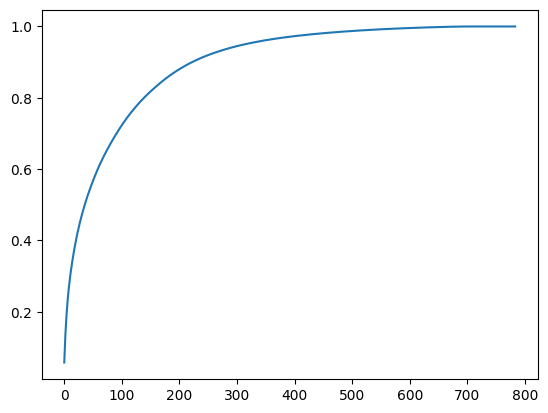

In [40]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))